<a href="https://colab.research.google.com/github/OthmaneAbder2303/Practical-Deep-Learning/blob/main/non-linear%20topology/age_gender_functional_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 93% 309M/331M [00:00<00:00, 401MB/s]
100% 331M/331M [00:00<00:00, 403MB/s]


In [2]:
import zipfile
zip = zipfile.ZipFile("utkface-new.zip",'r')
zip.extractall("/sample_data/")
zip.close()

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
folder_path = '/sample_data/utkface_aligned_cropped/UTKFace'

In [5]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [6]:
len(age)

23708

In [7]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [8]:
df.shape

(23708, 3)

In [9]:
df.head()

,age,gender,img
0,2,1,2_1_4_20161221195838329.jpg.chip.jpg
1,54,1,54_1_0_20170117191523029.jpg.chip.jpg
2,14,0,14_0_1_20170113145153262.jpg.chip.jpg
3,24,1,24_1_2_20170116170616076.jpg.chip.jpg
4,90,0,90_0_0_20170111210753614.jpg.chip.jpg


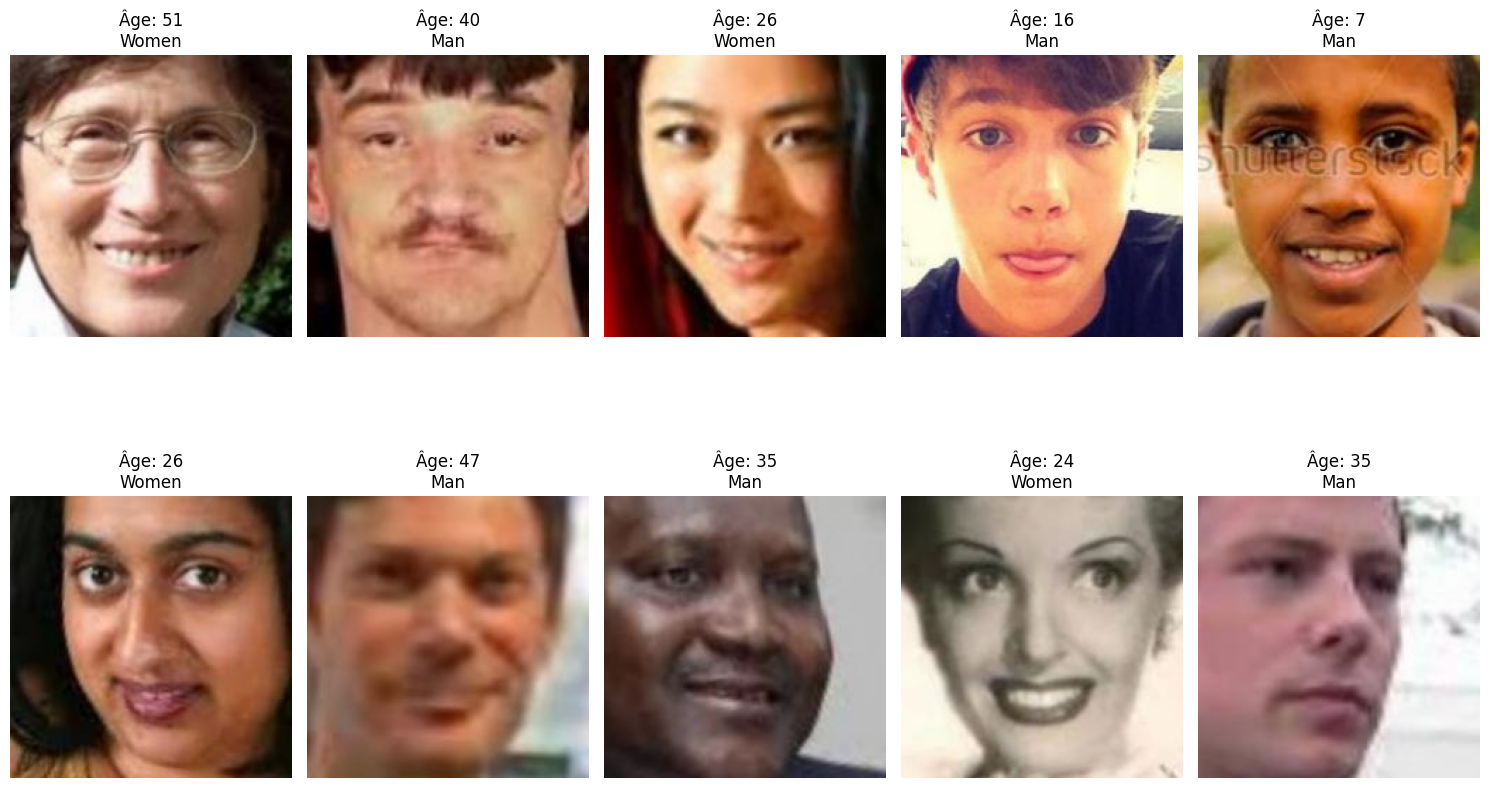

In [10]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

sample_df = df.sample(10)

for i, (index, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 5, i + 1)

    img_full_path = os.path.join(folder_path, row['img'])
    image = cv2.imread(img_full_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    gender_label = "Man" if row['gender'] == 0 else "Women"

    plt.imshow(image)
    plt.title(f"Âge: {row['age']}\n{gender_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [12]:
train_df.shape

(20000, 3)

In [13]:
test_df.shape

(3708, 3)

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age','gender'],
    target_size=(200,200),
    class_mode='raw'
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [16]:
def final_multi_output_wrapper(gen):
    for x, y in gen:
        yield x, {
            'age': y[:, 0].astype('float32'),
            'gender': y[:, 1].astype('float32')
        }

train_gen_final = final_multi_output_wrapper(train_generator)
test_gen_final = final_multi_output_wrapper(test_generator)

In [17]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [18]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

#resnet.trainable = False
resnet.trainable = True
for layer in resnet.layers[:-30]:
    layer.trainable = False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [20]:
model = Model(inputs=resnet.input,outputs=[output1,output2])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 126,875,522 (483.99 MB)

 Trainable params: 117,737,986 (449.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [21]:
model.compile(
    optimizer='adam',
    loss={
        'age': 'mae',
        'gender': 'binary_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy'
    },
    loss_weights={
        'age':1.0,
        'gender':15.0
    }
)

In [ ]:
history = model.fit(
    train_gen_final,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_gen_final,
    validation_steps=len(test_generator)
)

Epoch 1/10
251/625 ━━━━━━━━━━━━━━━━━━━━ 2:14 359ms/step - age_loss: 19.2700 - age_mae: 19.2700 - gender_accuracy: 0.5087 - gender_loss: 2.8019 - loss: 61.2986